## Introduction

In this notebook, the relationships between homelessness and data about the area (e.g. local housing market factors and demographics) will be investigated using data science methodologies.

## Import libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

import statsmodels.api as sm

from sklearn import tree
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler

from functools import partial

import graphviz

from scipy.stats import uniform, randint
import xgboost as xgb

## Load clean data

The data set imported by this notebook comes from from the US Department of Housing and Urban Development. Details about this data are available in the HUD's report [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) in the section titled DATA.

The data preparation was documented in the [data preparation notebook](https://github.com/charlier-su/homelessness-data/blob/main/homelessness_data_preparation.ipynb). The prepared data set is available as a csv file in the GitHub repository as [homelessness_data_clean.csv](https://github.com/charlier-su/homelessness-data/blob/main/homelessness_data_clean.csv). Here, it is imported into the notebook:

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/charlier-su/homelessness-data/main/homelessness_data_clean.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 44 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   coc_number                                  374 non-null    object 
 1   total_population                            374 non-null    int64  
 2   house_price_index_2009                      374 non-null    float64
 3   log_median_rent                             374 non-null    float64
 4   utility_costs                               374 non-null    float64
 5   percentage_owners_cost_burden_2016          374 non-null    float64
 6   percentage_renters_severe_cost_burden_2016  374 non-null    float64
 7   share_renters_2016                          374 non-null    float64
 8   rental_vacancy_rate                         374 non-null    float64
 9   high_housing_density                        374 non-null    int64  
 10  number_evictio

Above is a list of columns that we have available to us. We can see that there are 374 entries in the data set.

## Questions

- What types of models are most effective for predicting homelessness rates?
- Could federal funding (or lack of federal funding) contribute to homelessness rates?
- What factors have the closest relationship with homelessness rates?
  - More specifically, what predictors are most effective for estimating homelessness rates?

## Analysis

Our first set of predictors will be all columns, other than the identifier (`coc_number`), values directly related to what we are trying to predict (`rate_homeless`, `rate_sheltered`, and `rate_unsheltered`), and values we are saving for later (`federal_funding` and `federal_funding_change`).

In [29]:
identifiers = ['coc_number']
outcomes = ['rate_homeless', 'rate_sheltered', 'rate_unsheltered']
additional_step = ['federal_funding', 'federal_funding_change']
X = df.drop(columns = identifiers + outcomes + additional_step)
y = df['rate_homeless']

Before we build the models, the training data is scaled.

In [30]:
scaler = RobustScaler().fit(X)
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns.values, index=X.index)

Next, an OLS regression is made, so we can look at the significance of the coefficients:

In [31]:
ols_model = sm.OLS(y, sm.add_constant(X)).fit()

predictors = X.columns
predictors = np.insert(predictors, 0, 'intercept')

results = pd.DataFrame(index = predictors, 
                       data = {
                          'p-value': ols_model.pvalues.values.round(3), 
                          'significant': ols_model.pvalues.values < 0.05,
                          'coefficient': ols_model.params.values.round(2),
                          'abs_coefficient': \
                              np.abs(ols_model.params.values.round(2))
                       })

results.sort_values(by = 'abs_coefficient', ascending=False)

,p-value,significant,coefficient,abs_coefficient
intercept,0.000,True,16.01,16.01
log_median_rent,0.000,True,11.18,11.18
proportion_one_person_households,0.000,True,6.51,6.51
rate_black,0.013,True,-4.48,4.48
share_hud_units,0.003,True,4.37,4.37
suburban,0.063,False,-3.82,3.82
high_housing_density,0.111,False,-3.22,3.22
share_overcrowded_units_2016,0.028,True,2.86,2.86
migration_4_year_change,0.000,True,2.64,2.64
share_under_18_with_single_parent,0.310,False,2.50,2.50


We have a lot of predictors and not a lot of entries to work with. Also, we know that there are plenty of entries that are unusual, so we need to be careful about the train/test split. Whenever we want to benchmark a model, we'll use k-fold cross validation so that the train/test splits are less likely to affect the results.

In [32]:
def make_splits(X, y):
    kf = KFold(n_splits = 10)
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index,:]
        y_train = y.iloc[train_index]

        X_test = X.iloc[test_index,:]
        y_test = y.iloc[test_index]

        yield X_train, y_train, X_test, y_test

For any model we create, we'll want to see the MSE, RMSE, and MAE (mean absolute error).

In [33]:
def evaluate_model(X_train, y_train, X_test, y_test, model_from_train,
                   prediction_from_model):
    model = model_from_train(X_train, y_train)
    y_pred = prediction_from_model(model, X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, rmse, mae

def show_model_performance(X, y, model_from_train, prediction_from_model):
    mse_values = []
    rmse_values = []
    mae_values = []

    for X_train, y_train, X_test, y_test in make_splits(X, y):
        mse, rmse, mae = evaluate_model(X_train, y_train, X_test,
                                        y_test, model_from_train,
                                        prediction_from_model)
        
        mse_values.append(mse)
        rmse_values.append(rmse)
        mae_values.append(mae)

    mse, rmse, mae = evaluate_model(X, y, X, y, model_from_train,
                                    prediction_from_model)
    print('Without train/test CV:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print()
    print('With train/test CV:')
    print(f'MSE: {np.mean(mse_values)}')
    print(f'RMSE: {np.mean(rmse_values)}')
    print(f'MAE: {np.mean(mae_values)}')

Let's look at our OLS regression:

In [34]:
def ols_model(X_train, y_train):
    return sm.OLS(y_train, sm.add_constant(X_train)).fit()

def ols_prediction(model, X_test):
    return model.predict(sm.add_constant(X_test))

show_model_performance(X, y, ols_model, ols_prediction)

Without train/test CV:
MSE: 101.28089977395058
RMSE: 10.063841203732826
MAE: 6.730016523656087

With train/test CV:
MSE: 178.9450617040727
RMSE: 12.424576749052267
MAE: 8.201917866201905


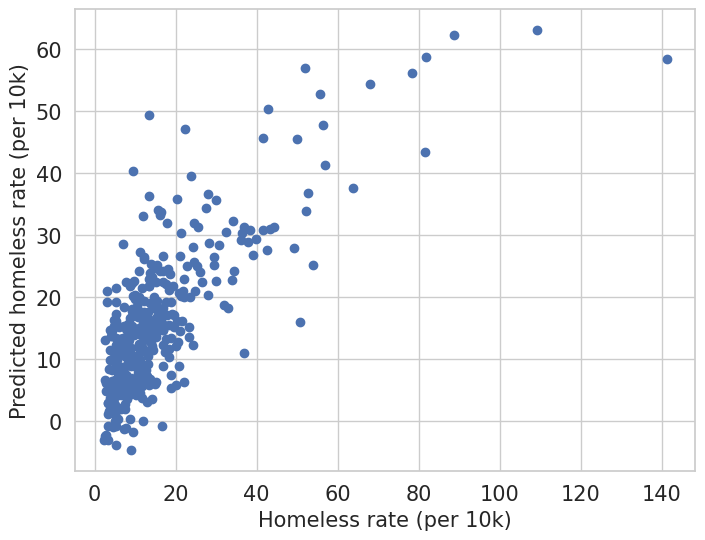

In [35]:
model = ols_model(X, y)
y_pred_ols = ols_prediction(model, X)

plt.figure(figsize = (8,6))

plt.plot(y, y_pred_ols, 'o');

plt.xlabel('Homeless rate (per 10k)', fontsize = 15)
plt.ylabel('Predicted homeless rate (per 10k)', fontsize = 15)

plt.tick_params(labelsize = 15)

This doesn't look too bad, but a MAE of 8.20 isn't ideal. This could be from overfitting, or the extreme values in the data set, or the non-linear relationships. An OLS model on the data, as-is, is probably not the way we want to go. We'll try a ridge regression to make the data easier to model:

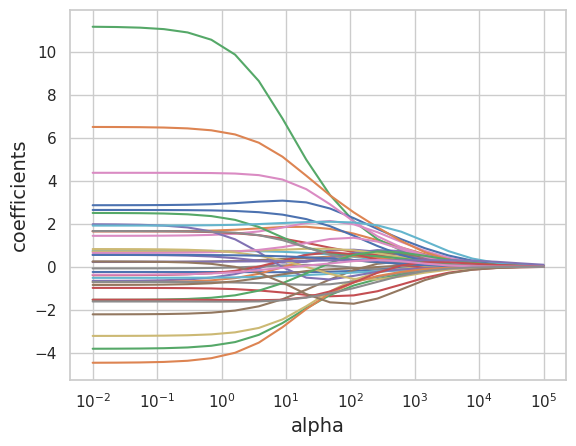

In [36]:
alphas = 10**np.linspace(-2, 5, 20)
ridge = Ridge(max_iter = 100000)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha', fontsize = 14)
plt.ylabel('coefficients', fontsize = 14);

In [37]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, scoring = 'neg_mean_squared_error')
ridgecv.fit(X, y)

RidgeCV(alphas=array([1.00000000e-02, 2.33572147e-02, 5.45559478e-02, 1.27427499e-01,
       2.97635144e-01, 6.95192796e-01, 1.62377674e+00, 3.79269019e+00,
       8.85866790e+00, 2.06913808e+01, 4.83293024e+01, 1.12883789e+02,
       2.63665090e+02, 6.15848211e+02, 1.43844989e+03, 3.35981829e+03,
       7.84759970e+03, 1.83298071e+04, 4.28133240e+04, 1.00000000e+05]),
        cv=5, scoring='neg_mean_squared_error')

In [38]:
def ridge_model(X_train, y_train):
    return Ridge(alpha = ridgecv.alpha_).fit(X_train, y_train)
    
def ridge_prediction(model, X_test):
  return model.predict(X_test)

show_model_performance(X, y, ridge_model, ridge_prediction)

Without train/test CV:
MSE: 112.22422471124146
RMSE: 10.593593569287123
MAE: 6.717042130589058

With train/test CV:
MSE: 154.48107294026863
RMSE: 11.358633004309647
MAE: 7.521215675648972


Having a mean absolute error of 7.52 means that we're in the right direction. This means we're doing better than we would if we were to guess based on the average value of `rate_homeless`.

A simple tree model:

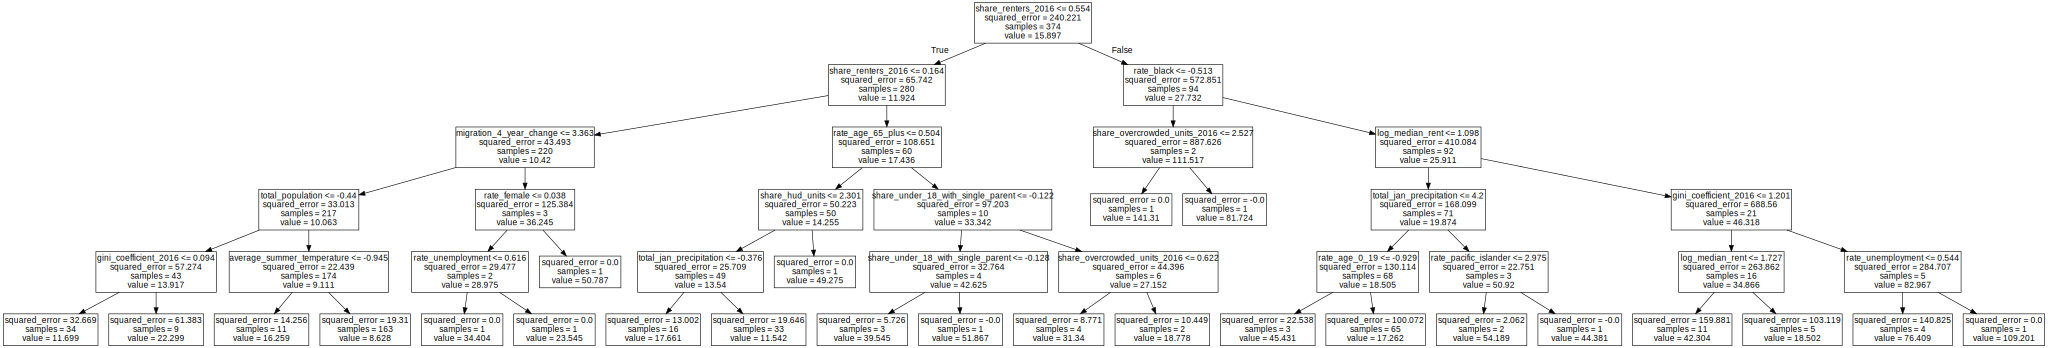

In [39]:
def tree_model(X_train, y_train):
    model = tree.DecisionTreeRegressor(max_depth = 5)
    model.fit(X_train, y_train)
    return model
    
def tree_prediction(model, X_test):
    return model.predict(X_test)

model = tree_model(X, y)
tree_data = tree.export_graphviz(model, out_file=None, feature_names=X.columns) 
graph = graphviz.Source(tree_data) 
graph

In [40]:
show_model_performance(X, y, tree_model, tree_prediction)

Without train/test CV:
MSE: 40.938744699631
RMSE: 6.39833921417355
MAE: 4.467288400456557

With train/test CV:
MSE: 263.80690487671666
RMSE: 14.300604214598769
MAE: 8.629181321018024


This model is also more effective than guessing, but it doesn't improve on the one that came out of the ridge regression. Next, we can try XGBoost:

In [41]:
def basic_xgb_model(X_train, y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    param = {'max_depth': 3, 'eta': 0.3, 'objective': 'reg:squarederror'}
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)
    return bst

def basic_xgb_prediction(model, X_test):
    return model.predict(xgb.DMatrix(X_test))

show_model_performance(X, y, basic_xgb_model, basic_xgb_prediction)

Without train/test CV:
MSE: 36.86439597231697
RMSE: 6.071605716144369
MAE: 4.489173518371313

With train/test CV:
MSE: 164.0251598928939
RMSE: 11.41612978444372
MAE: 7.4470508100618265


We were able to get performance comparable to the ridge regression with XGBoost using basic values for the parameters. This means we might be able to get our best model yet, if we fine-tune the parameters:

In [42]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')

params = {
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'learning_rate': uniform(0.03, 0.3),
    'max_depth': randint(2, 6),
    'n_estimators': randint(100, 150),
    'subsample': uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring = 'neg_mean_squared_error')

search.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3886684520>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3886684f70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3886684c70>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f38866853c0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [43]:
def xgb_model(X_train, y_train):
    model = xgb.XGBRegressor(objective = 'reg:squarederror')
    model.set_params(**search.best_params_)
    model.fit(X_train, y_train)
    return model

def xgb_prediction(model, X_test):
    return model.predict(X_test)

show_model_performance(X, y, xgb_model, xgb_prediction)

Without train/test CV:
MSE: 0.3964586190280614
RMSE: 0.6296496001968567
MAE: 0.4882476549703371

With train/test CV:
MSE: 136.8535572380936
RMSE: 10.453957132059735
MAE: 6.883997208447934


So far, the best model was able to predict homelessness rates (counter per 10,000) with a mean absolute error of 6.88. Let's investigate what predictors are most influential in these estimates:

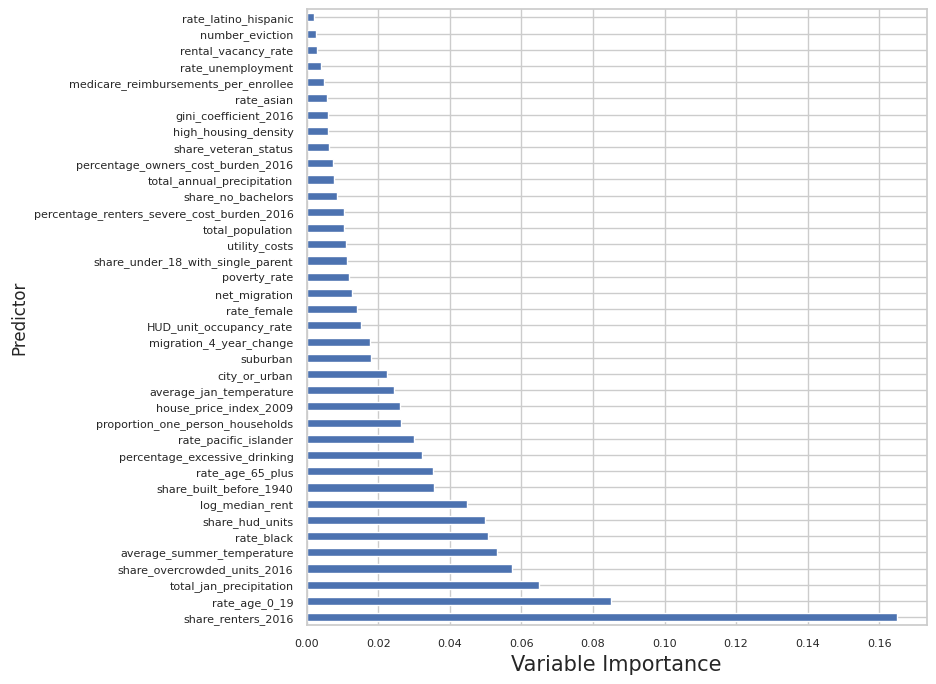

In [44]:
model = xgb_model(X, y)

importances = pd.DataFrame({
    'predictor': X.columns, 
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importances.plot('predictor', 'importance', 'barh', legend = False,
                 figsize = (8, 8))
plt.ylabel('Predictor')
plt.xlabel('Variable Importance', fontsize = 15)

plt.tick_params(labelsize = 8)

This looks fairly different from our original OLS model, but the OLS model did not perform better than guessing.

From this plot, we can tell that the biggest predictors of homelessness are:

* Share of housing units that are rented as opposed to owned
* Precipitation in January
* How much of the population is under 19
* The median rent in the area
* The proportion of overcrowded housing units
* The age of the houses (what proportion of them were built before 1940)



### Additional Step: Funding Data

We'll make an adjusted version of `X` to include federal funding data, to see if it helps the performance of our models:

In [45]:
X_adj = X.copy()
X_adj['federal_funding'] = df['federal_funding']
X_adj['federal_funding_change'] = df['federal_funding_change']

We start with our XGBoost model:

In [46]:
show_model_performance(X_adj, y, xgb_model, xgb_prediction)

Without train/test CV:
MSE: 0.5274916655286435
RMSE: 0.7262862146073292
MAE: 0.551602178184999

With train/test CV:
MSE: 136.6927950889866
RMSE: 10.492696785119534
MAE: 6.829000168052249


Looks like it didn't help us here. The fine-tuned parameters for the XGBoost model didn't account for the federal funding data, so maybe we'll see a difference if we make a new OLS model:

In [47]:
show_model_performance(X_adj, y, ols_model, ols_prediction)

Without train/test CV:
MSE: 95.91966498449072
RMSE: 9.793858534024816
MAE: 6.588103841430767

With train/test CV:
MSE: 176.91319046334942
RMSE: 12.31805293990953
MAE: 8.292509775037217


This isn't any better, either. Out of curiosity, let's check and see if the XGBoost model made any significant use of the federal funding predictors, in place of something else:

In [48]:
model = xgb_model(X_adj, y)

pd.DataFrame({
    'predictor': X_adj.columns, 
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

,predictor,importance
6,share_renters_2016,0.176258
35,rate_age_0_19,0.096558
28,average_summer_temperature,0.086445
10,share_overcrowded_units_2016,0.063943
29,total_jan_precipitation,0.057481
31,rate_black,0.050087
16,share_hud_units,0.047992
27,average_jan_temperature,0.034473
11,city_or_urban,0.032181
2,log_median_rent,0.030337


`federal_funding` and `federal_funding_change` both have an importance under 0.01.

We'll try one more thing: can the funding data, by itself, tell us anything about the homelessness rate?

In [49]:
X_funding = X_adj[['federal_funding', 'federal_funding_change']]
show_model_performance(X_funding, y, ols_model, ols_prediction)

Without train/test CV:
MSE: 217.29777788543495
RMSE: 14.74102363763911
MAE: 9.115498214498793

With train/test CV:
MSE: 228.61953964975942
RMSE: 13.23609473179763
MAE: 9.421818131499233


A mean absolute error of 9.42 means that, as the data is, there's not much we can make of it.

## Conclusion


This purpose of this analysis was to predict homelessness rates in various cities in the US and to identify which factors contribute most significantly to homelessness rates. The OLS regression model in the preliminary analysis was not helpful, but as different types of models were used we were able to create several that outperform guesses based on average rates. It was discovered that the best model was an XGBoost model with fine-tuned parameters based on the homelessness data. It had a mean absolute error of 6.88. From this model, it looks like the most important factors contributing to homelessness are:
* The proportion of housing units that are rented as opposed to owned.
* Precipitation in January.
* The proportion of the population under 19 years of age.
* Median rent in the area.
* The proportion of overcrowded housing units.
* The age of the houses, particularly the proportion built before 1940.

This isn't to say that these directly cause homelessness, rather, that these factors most heavily influence the predictions of the most accurate model, and therefore appear to have a connection to homelessness rates.

Some of the models were modified to incorporate federal funding data in an effort to improve the prediction accuracy. No improvement was found by using this data, and the XGBoost model assigned minimal importance to those predictors.